# Psychometrics.ai

In [1]:
# installation command for packages: openai, numpy, scikit-learn, pandas, tqdm, and faiss-cpu. First time only.
# !pip install openai numpy scikit-learn pandas tqdm faiss-cpu

In [2]:
#Imports pandas, numpy, and OpenAI library; initializes OpenAI client.
import pandas as pd
import numpy as np
from openai import OpenAI

openai_client = OpenAI()

In [3]:
#Reads CSV file into a DataFrame called items_df, prints row count, and displays first 5 rows.
items_df = pd.read_csv('TedoneItemAssignmentTable30APR21.csv')
print(f"Loaded {len(items_df)} items")
items_df.head()

Loaded 3805 items


,instrument,alpha,key,text,label
0,16PF,0.78,1,Act wild and crazy.,Gregariousness
1,16PF,0.8,1,Am afraid that I will do the wrong thing.,Anxiety
2,16PF,0.76,1,Am annoyed by others' mistakes.,Emotionality
3,16PF,0.85,-1,Am easily discouraged.,Emotional Stability
4,16PF,0.8,1,Am easily hurt.,Anxiety


In [4]:
# Generates embeddings for all items in items_df['text'] using OpenAI's API. 
# Processes in batches of 100 for efficiency, tracks progress/cost, handles errors, 
# adds embeddings as a new column.

from tqdm import tqdm  # Progress bar library
import time  # For timing the process

def get_embeddings_batch(texts):
    """
    Get embeddings for multiple texts in a single API call.
    This is much faster than calling the API for each item individually.
    OpenAI allows up to 2048 texts per batch.
    """
    response = openai_client.embeddings.create(
        model="text-embedding-3-small",  # Cost-effective embedding model
        input=texts  # List of texts to embed
    )
    # Extract just the embedding vectors from the response
    return [item.embedding for item in response.data]

# Initialize tracking variables
embeddings = []  # Will store all embedding vectors
batch_size = 100  # Number of items to send per API call
start_time = time.time()  # Track total time
total_tokens = 0  # Track tokens for cost calculation

print(f"Embedding {len(items_df)} items in batches of {batch_size}...")

# Loop through dataframe in chunks of batch_size
for i in tqdm(range(0, len(items_df), batch_size)):
    # Get the next batch of item texts
    batch_texts = items_df['text'][i:i+batch_size].tolist()
    
    try:
        # Send entire batch to API in one call
        batch_embs = get_embeddings_batch(batch_texts)
        embeddings.extend(batch_embs)  # Add batch results to our list
        
        # Estimate tokens used (rough: 4 chars = 1 token)
        batch_tokens = sum(len(str(t))/4 for t in batch_texts)
        total_tokens += batch_tokens
        
    except Exception as e:
        # If batch fails, log error and add None placeholders
        print(f"\nError on batch {i}: {e}")
        embeddings.extend([None] * len(batch_texts))

# Add embeddings as new column in dataframe
items_df['embedding'] = embeddings

# Calculate and display final statistics
elapsed = time.time() - start_time
final_cost = (total_tokens / 1_000_000) * 0.02  # $0.02 per 1M tokens
print(f"\n✓ Time: {elapsed/60:.1f} min | Cost: ${final_cost:.4f}")
print(f"✓ Success: {sum(1 for e in embeddings if e is not None)}/{len(items_df)}")

Embedding 3805 items in batches of 100...


100%|████████████████████████████████████████████████| 39/39 [00:30<00:00,  1.26it/s]


✓ Time: 0.5 min | Cost: $0.0006
✓ Success: 3805/3805


In [5]:
# Converts embeddings from DataFrame format to a numpy matrix for FAISS (similarity search library),
# Converts to float32 (required by FAISS) and prints dimensions to verify,

import faiss

# Convert embeddings to numpy array (FAISS needs this format)
embedding_matrix = np.array(items_df['embedding'].tolist()).astype('float32')

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Dimension: {embedding_matrix.shape[1]}")


Embedding matrix shape: (3805, 1536)
Dimension: 1536


In [6]:
# Creates a FAISS index for fast similarity search, 
# Uses L2 distance (Euclidean) to measure similarity between embeddings,
# Adds all item vectors to the index and confirms count, 
# FAISS uses "index" as a general term for any searchable structure, embeddings are the index!
    
dimension = embedding_matrix.shape[1]  # 1536
index = faiss.IndexFlatL2(dimension)  # L2 distance for similarity

# Add all vectors to the index
index.add(embedding_matrix)

print(f"✓ FAISS index built with {index.ntotal} vectors")

✓ FAISS index built with 3805 vectors


In [7]:
# Show retrieval in action
# Prompts user for scale name, description, and number of results,
# Combines inputs into query string, embeds it, searches FAISS for k most similar items, 
# displays results with labels, text, and distances.
# For validation, this must use a label that exists in the IPIP database!
# We choose Achievement-striving:
# A strong drive to excel, pursue challenging goals, work hard, persist through difficulty, and maintain high personal performance standards.

def get_embedding(text):
    """Get embedding for a single text"""
    response = openai_client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return response.data[0].embedding

# Interactive prompts
scale_label = input("Enter scale name: ")
scale_description = input("Enter brief description of what it measures: ")
k = int(input("How many similar items to retrieve? (default 5): ") or 5)

# Combine inputs
query = f"{scale_label}: {scale_description}"

# Embed the query
query_embedding = get_embedding(query)
query_vector = np.array([query_embedding]).astype('float32')

# Search for most similar items
distances, indices = index.search(query_vector, k)

# Show results
print(f"\nQuery: '{query}'\n")
print("="*60)
for i, idx in enumerate(indices[0]):
    print(f"{i+1}. [{items_df.iloc[idx]['label']}] {items_df.iloc[idx]['text']}")
    print(f"   Distance: {distances[0][i]:.3f}\n")

Enter scale name:  Achievement-striving
Enter brief description of what it measures:  A strong drive to excel, pursue challenging goals, work hard, persist through difficulty, and maintain high personal performance standards.
How many similar items to retrieve? (default 5):  20



Query: 'Achievement-striving: A strong drive to excel, pursue challenging goals, work hard, persist through difficulty, and maintain high personal performance standards.'

1. [Perfectionism] Strive in every way possible to be flawless.
   Distance: 0.933

2. [Diligence] Push myself very hard to succeed.
   Distance: 0.998

3. [Ambition/Drive] Push myself very hard to succeed.
   Distance: 0.998

4. [Industriousness/Perseverance/Persistence] Am a goal-oriented person.
   Distance: 1.020

5. [Dominance] Try to surpass others' accomplishments.
   Distance: 1.028

6. [Ambition/Drive] Try to surpass others' accomplishments.
   Distance: 1.028

7. [Assertiveness] Try to surpass others' accomplishments.
   Distance: 1.028

8. [Achievement-striving] Try to surpass others' accomplishments.
   Distance: 1.028

9. [Locus of Control,Internal] Believe that by working hard a person can achieve anything.
   Distance: 1.047

10. [Achievement-striving] Want to be the very best.
   Distance: 1.063

11.


VALIDATION for 'Achievement-striving'
Retrieved: 20 items
Total 'Achievement-striving' items in database: 32

Metrics:
  Precision (% retrieved that are correct): 4/20 (20.0%)
  Recall (% of all correct items found): 4/32 (12.5%)
  F1 Score (balance of precision & recall): 0.154
  First correct match: Position 8


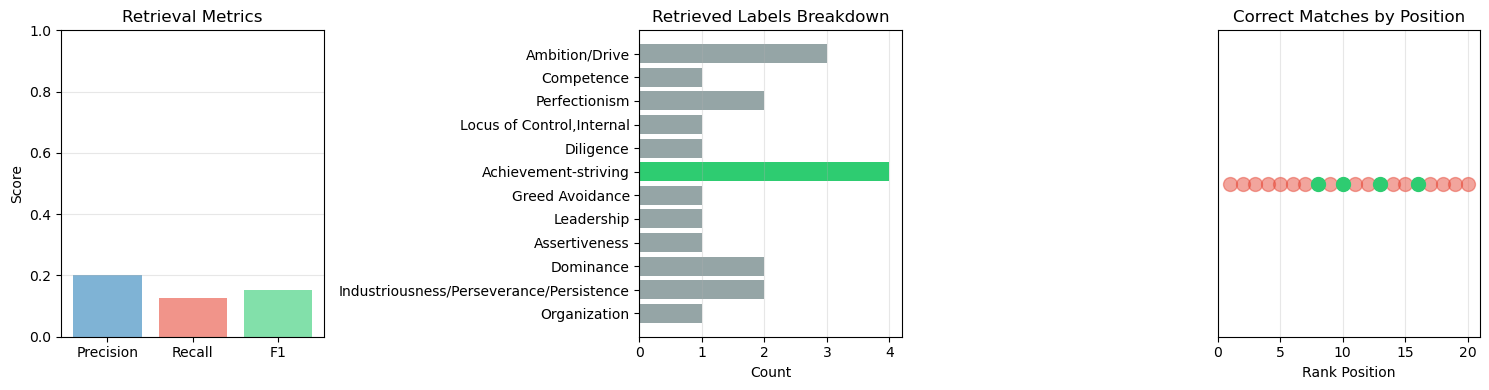

In [8]:
# Validates retrieval from previous cell by calculating precision, recall, and F1 metrics; 
# prints text results; 
# then creates 3 plots showing (1) metrics comparison bar chart, (2) horizontal bar chart of retrieved label counts with target scale highlighted, and (3) scatter plot showing positions of correct vs incorrect matches in the ranking.

import matplotlib.pyplot as plt

# Validation code 
retrieved_labels = [items_df.iloc[idx]['label'] for idx in indices[0]]
matches = sum(1 for label in retrieved_labels if label == scale_label)
precision = matches / k
total_scale_items = len(items_df[items_df['label'] == scale_label])
recall = matches / total_scale_items if total_scale_items > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
first_correct_pos = next((i+1 for i, label in enumerate(retrieved_labels) if label == scale_label), None)

# Print metrics (same as before)
print(f"\n{'='*60}")
print(f"VALIDATION for '{scale_label}'")
print(f"{'='*60}")
print(f"Retrieved: {k} items")
print(f"Total '{scale_label}' items in database: {total_scale_items}")
print(f"\nMetrics:")
print(f"  Precision (% retrieved that are correct): {matches}/{k} ({precision:.1%})")
print(f"  Recall (% of all correct items found): {matches}/{total_scale_items} ({recall:.1%})")
print(f"  F1 Score (balance of precision & recall): {f1:.3f}")
print(f"  First correct match: Position {first_correct_pos}")

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Metrics bar chart
axes[0].bar(['Precision', 'Recall', 'F1'], [precision, recall, f1], color=['#7FB3D5', '#F1948A', '#82E0AA'])
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Score')
axes[0].set_title('Retrieval Metrics')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Label breakdown
label_counts = {label: retrieved_labels.count(label) for label in set(retrieved_labels)}
colors = ['#2ecc71' if label == scale_label else '#95a5a6' for label in label_counts.keys()]
axes[1].barh(list(label_counts.keys()), list(label_counts.values()), color=colors)
axes[1].set_xlabel('Count')
axes[1].set_title('Retrieved Labels Breakdown')
axes[1].grid(axis='x', alpha=0.3)

# Plot 3: Ranking positions of correct matches
correct_positions = [i+1 for i, label in enumerate(retrieved_labels) if label == scale_label]
axes[2].scatter(correct_positions, [1]*len(correct_positions), s=100, color='#2ecc71', zorder=3)
axes[2].scatter([i+1 for i in range(k) if retrieved_labels[i] != scale_label], 
                [1]*len([i for i in range(k) if retrieved_labels[i] != scale_label]), 
                s=100, color='#e74c3c', alpha=0.5, zorder=2)
axes[2].set_xlim(0, k+1)
axes[2].set_ylim(0.5, 1.5)
axes[2].set_xlabel('Rank Position')
axes[2].set_title('Correct Matches by Position')
axes[2].set_yticks([])
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Defines RAG function that (1) retrieves similar items from FAISS, (2) formats them as context, (3) sends to GPT-4o-mini to generate new personality items in similar style. 
# Prompts user for scale name, description, and count; displays both generated items and the retrieved context examples used.

def generate_items(scale_description, n_items=5, n_retrieve=10):
    """
    Generate new personality items using RAG.
    
    Args:
        scale_description: What the scale measures
        n_items: Number of items to generate
        n_retrieve: Number of similar items to retrieve as context
    """
    # 1. Embed the query
    query_embedding = get_embedding(scale_description)
    query_vector = np.array([query_embedding]).astype('float32')
    
    # 2. Retrieve similar items from FAISS
    distances, indices = index.search(query_vector, n_retrieve)
    
    # 3. Format retrieved items as context
    context_items = []
    for idx in indices[0]:
        item = items_df.iloc[idx]
        context_items.append(f"[{item['label']}] {item['text']}")
    
    context = "\n".join(context_items)
    
    # 4. Generate with GPT
    prompt = f"""You are writing personality test items. Based on these example items:

{context}

Generate {n_items} new items that measure: {scale_description}

Requirements:
- Short, clear statements (5-15 words)
- Avoid mentioning the scale name in the item
- First-person perspective ("I...")
- Mix of positively and negatively keyed items
- Varied phrasing

Return only the items, one per line."""

    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content, context

# Interactive prompts
scale_label = input("Enter scale name: ")
scale_description = input("Enter brief description of what it measures: ")
n_items = int(input("How many items to generate? (default 5): ") or 5)

# Combine inputs
full_query = f"{scale_label}: {scale_description}"

print(f"\n🔍 Searching for similar items...")
new_items, context = generate_items(full_query, n_items=n_items)

print("\n" + "="*60)
print("GENERATED ITEMS:")
print("="*60)
print(new_items)
print("\n" + "="*60)
print("RETRIEVED CONTEXT:")
print("="*60)
print(context)

Enter scale name:  Fairness/Cheating
Enter brief description of what it measures:  Commitment to fairness and proportionality in dealings with others; contrasted with comfort with exploitation or uneven application of standards.
How many items to generate? (default 5):  20



🔍 Searching for similar items...

GENERATED ITEMS:
I believe in treating everyone fairly.  
I often let others take advantage of me.  
I think everyone deserves equal opportunities.  
I can overlook unfair treatment if it benefits me.  
I feel strongly about upholding fairness in conflicts.  
I am comfortable when rules don't apply to everyone.  
I strive to balance contributions and rewards.  
I can tolerate inequality to maintain relationships.  
I seek to resolve disputes with fairness in mind.  
I sometimes bend rules to suit my needs.  
I prioritize fair outcomes over personal gain.  
I believe some people deserve preferential treatment.  
I advocate for just and equitable solutions.  
I find it acceptable to exploit loopholes for advantage.  
I aim to distribute resources according to need.  
I often disregard fairness if it complicates matters.  
I feel guilty if I benefit at someone else’s expense.  
I think it’s okay to play favorites sometimes.  
I work to ensure consistent 

In [10]:
# Without RAG - comparison to previous RAG generation
def generate_items_no_rag(scale_description, n_items=10):
    """Generate items WITHOUT RAG - just GPT with no context."""
    prompt = f"""You are writing personality test items.
Generate {n_items} new items that measure: {scale_description}
Requirements:
- Short, clear statements (5-15 words)
- Avoid mentioning the scale name in the item
- First-person perspective ("I...")
- Mix of positively and negatively keyed items
- Varied phrasing
Return only the items, one per line."""
    
    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

# Use same inputs from previous cell
full_query = f"{scale_label}: {scale_description}"

print("\n" + "="*60)
print("WITHOUT RAG (No Context):")
print("="*60)
no_rag_items = generate_items_no_rag(full_query, n_items)
print(no_rag_items)

print("\n" + "="*60)
print("WITH RAG (From Previous Cell):")
print("="*60)
print(new_items)

print("\n" + "="*60)
print("CONTEXT USED IN RAG:")
print("="*60)
print(context)


WITHOUT RAG (No Context):
1. I believe everyone deserves an equal chance.  
2. I often find rules can be bent for the right reasons.  
3. I strive to treat others just as I want to be treated.  
4. I am comfortable taking advantage of loopholes.  
5. I would never cheat to get ahead.  
6. I think some people deserve special treatment.  
7. I stand up for those who are being treated unfairly.  
8. I find it easy to overlook unfairness if it benefits me.  
9. I feel guilty when I don't speak up for fairness.  
10. I believe that fairness can slow down progress.  
11. I prioritize honesty and transparency in my interactions.  
12. I think breaking the rules can sometimes be justified.  
13. I work to create an inclusive and equitable environment.  
14. I think some rules are meant to be ignored.  
15. I consistently advocate for those who are marginalized.  
16. I often rationalize my decisions to fit my needs.  
17. I value fairness in both personal and professional relationships.  
18.

In [11]:
# Parses RAG and no-RAG generated items into lists, 
# Embeds each item plus the scale definition, 
# Calculates cosine similarity between each item and the definition. 
# Creates two lists of similarity scores measuring how semantically aligned each generated item is with the target construct.

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Parse the generated items into lists
rag_items_list = [item.strip() for item in new_items.split('\n') if item.strip()]
no_rag_items_list = [item.strip() for item in no_rag_items.split('\n') if item.strip()]

# Embed all items
print("Embedding generated items...")
rag_embeddings = [get_embedding(item) for item in rag_items_list]
no_rag_embeddings = [get_embedding(item) for item in no_rag_items_list]

# Embed the construct definition from earlier input
construct_embedding = get_embedding(scale_description)

# Calculate cosine similarities
rag_similarities = [cosine_similarity([construct_embedding], [emb])[0][0] 
                    for emb in rag_embeddings]
no_rag_similarities = [cosine_similarity([construct_embedding], [emb])[0][0] 
                       for emb in no_rag_embeddings]

Embedding generated items...


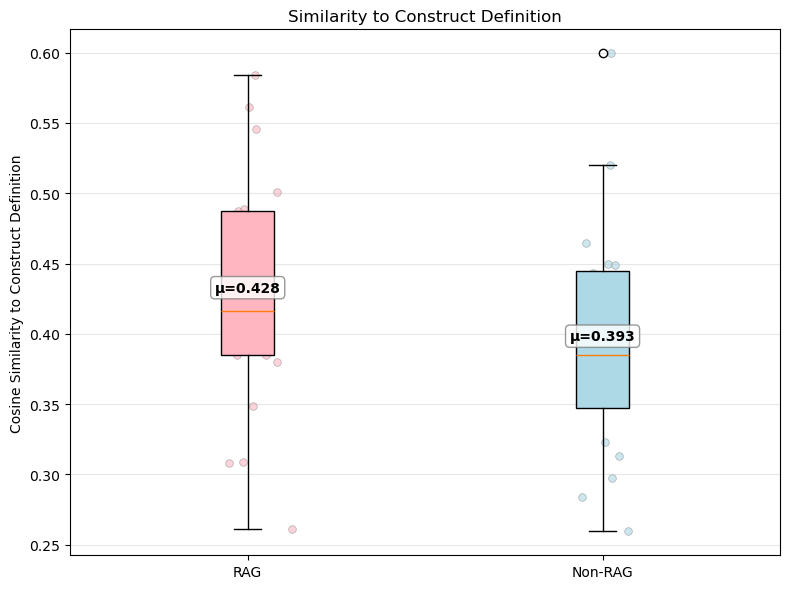


SUMMARY STATISTICS
RAG Mean Similarity: 0.4278 (SD: 0.0824)
Non-RAG Mean Similarity: 0.3933 (SD: 0.0801)

Difference in means: 0.0345


In [12]:
# Creates boxplot comparing RAG vs no-RAG item similarities to construct definition, 
# Individual data points overlaid using jitter for visibility. 
# Shows distribution and central tendency of how well each method's items align with target construct.

import numpy as np

plt.figure(figsize=(8, 6))
bp = plt.boxplot([rag_similarities, no_rag_similarities], labels=['RAG', 'Non-RAG'],
                  patch_artist=True)

# Color the boxes
colors = ['#FFB6C1', '#ADD8E6']  # pastel pink and blue
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add individual points with jitter
for i, (similarities, color) in enumerate(zip([rag_similarities, no_rag_similarities], colors), 1):
    x = np.random.normal(i, 0.04, size=len(similarities))
    plt.scatter(x, similarities, alpha=0.6, s=30, color=color, edgecolors='gray', linewidth=0.5)

# Add mean value annotations on the boxes
means = [np.mean(rag_similarities), np.mean(no_rag_similarities)]
for i, mean in enumerate(means, 1):
    plt.text(i, mean, f'μ={mean:.3f}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold', 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8))

plt.ylabel('Cosine Similarity to Construct Definition')
plt.title('Similarity to Construct Definition')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"RAG Mean Similarity: {np.mean(rag_similarities):.4f} (SD: {np.std(rag_similarities):.4f})")
print(f"Non-RAG Mean Similarity: {np.mean(no_rag_similarities):.4f} (SD: {np.std(no_rag_similarities):.4f})")
print(f"\nDifference in means: {abs(np.mean(rag_similarities) - np.mean(no_rag_similarities)):.4f}")

# Reranking

In [14]:
# Cell 1: Implements re-ranking and shows metrics
# Re-ranking using cross-encoder for better semantic matching
# Install sentence-transformers if needed: !pip install sentence-transformers

from sentence_transformers import CrossEncoder

# Initialize cross-encoder model (better at ranking than bi-encoders)
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Use Fairness/Cheating (from Cell 9 generation example)
scale_label = "Fairness/Cheating"
scale_description = "Commitment to fairness and proportionality in dealings with others; contrasted with comfort with exploitation or uneven application of standards."
query = f"{scale_label}: {scale_description}"
k = 10

print(f"Analyzing scale: {scale_label}")
print(f"Description: {scale_description}\n")

# Get initial FAISS results
query_embedding = get_embedding(query)
query_vector = np.array([query_embedding]).astype('float32')
distances, indices = index.search(query_vector, k * 10)  # Retrieve more candidate items

# Calculate ORIGINAL FAISS metrics (top-k only)
retrieved_labels_original = [items_df.iloc[idx]['label'] for idx in indices[0][:k]]
matches_original = sum(1 for label in retrieved_labels_original if label == scale_label)
total_scale_items = len(items_df[items_df['label'] == scale_label])
precision_original = matches_original / k
recall_original = matches_original / total_scale_items if total_scale_items > 0 else 0
f1_original = 2 * (precision_original * recall_original) / (precision_original + recall_original) if (precision_original + recall_original) > 0 else 0

# Create candidate pairs for cross-encoder
candidate_items = [(query, items_df.iloc[idx]['text']) for idx in indices[0]]

# Re-rank using cross-encoder
print("Re-ranking with cross-encoder...")
rerank_scores = cross_encoder.predict(candidate_items)

# Get top-k after re-ranking
reranked_indices = indices[0][np.argsort(rerank_scores)[::-1][:k]]

# Show re-ranked results
print(f"\nRe-ranked Query: '{query}'\n")
print("="*60)
for i, idx in enumerate(reranked_indices):
    print(f"{i+1}. [{items_df.iloc[idx]['label']}] {items_df.iloc[idx]['text']}")
    print(f"   Cross-encoder score: {rerank_scores[np.where(indices[0] == idx)[0][0]]:.4f}\n")

# Calculate metrics for re-ranked results
retrieved_labels_reranked = [items_df.iloc[idx]['label'] for idx in reranked_indices]
matches_reranked = sum(1 for label in retrieved_labels_reranked if label == scale_label)
precision_reranked = matches_reranked / k
recall_reranked = matches_reranked / total_scale_items if total_scale_items > 0 else 0
f1_reranked = 2 * (precision_reranked * recall_reranked) / (precision_reranked + recall_reranked) if (precision_reranked + recall_reranked) > 0 else 0
first_correct_reranked = next((i+1 for i, label in enumerate(retrieved_labels_reranked) if label == scale_label), None)

print(f"\n{'='*60}")
print(f"VALIDATION for '{scale_label}'")
print(f"{'='*60}")
print(f"\nOriginal FAISS Metrics:")
print(f"  Precision: {matches_original}/{k} ({precision_original:.1%})")
print(f"  Recall: {matches_original}/{total_scale_items} ({recall_original:.1%})")
print(f"  F1 Score: {f1_original:.3f}")
print(f"\nRe-ranked Metrics:")
print(f"  Precision: {matches_reranked}/{k} ({precision_reranked:.1%})")
print(f"  Recall: {matches_reranked}/{total_scale_items} ({recall_reranked:.1%})")
print(f"  F1 Score: {f1_reranked:.3f}")
print(f"  First correct match: Position {first_correct_reranked}")

/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Analyzing scale: Fairness/Cheating
Description: Commitment to fairness and proportionality in dealings with others; contrasted with comfort with exploitation or uneven application of standards.

Re-ranking with cross-encoder...

Re-ranked Query: 'Fairness/Cheating: Commitment to fairness and proportionality in dealings with others; contrasted with comfort with exploitation or uneven application of standards.'

1. [Equity/Fairness] Cheat on people who have trusted me.
   Cross-encoder score: -5.4432

2. [Prudence] Cannot imagine lying or cheating.
   Cross-encoder score: -5.5235

3. [Equity/Fairness] Am committed to principles of justice and equality.
   Cross-encoder score: -5.5990

4. [Sociability] Act comfortably with others.
   Cross-encoder score: -6.1416

5. [Distrust] Act comfortably with others.
   Cross-encoder score: -6.1416

6. [Social-discomfort] Act comfortably with others.
   Cross-encoder score: -6.1416

7. [Friendliness] Act comfortably with others.
   Cross-encoder scor

In [15]:
# Cell 2: Generate items using re-ranked context
# Uses the re-ranked results from Cell 1 to generate new items

# Reuse the re-ranked indices from Cell 1 (already calculated)
# Format re-ranked context
context_items_reranked = []
for idx in reranked_indices:
    item = items_df.iloc[idx]
    context_items_reranked.append(f"[{item['label']}] {item['text']}")
context_reranked = "\n".join(context_items_reranked)

# Use n_items from earlier (or set default)
if 'n_items' not in dir():
    n_items = 100

# Generate with re-ranked context
prompt_reranked = f"""You are writing personality test items. Based on these example items:

{context_reranked}

Generate {n_items} new items that measure: {scale_label}: {scale_description}

Requirements:
- Short, clear statements (5-15 words)
- Avoid mentioning the scale name in the item
- First-person perspective ("I...")
- Mix of positively and negatively keyed items
- Varied phrasing

Return only the items, one per line."""

print("Generating items with re-ranked context...")
response_reranked = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt_reranked}]
)

reranked_items = response_reranked.choices[0].message.content

print("\n" + "="*60)
print("GENERATED ITEMS (RE-RANKED RAG):")
print("="*60)
print(reranked_items)
print("\n" + "="*60)
print("RE-RANKED CONTEXT USED:")
print("="*60)
print(context_reranked)

Generating items with re-ranked context...

GENERATED ITEMS (RE-RANKED RAG):
I believe in treating everyone equally.  
I often bend the rules to benefit myself.  
I am committed to maintaining honesty in my dealings.  
I think it's acceptable to take advantage of others.  
I strive to be fair in all my interactions.  
I feel justified in manipulating situations to my advantage.  
I prioritize fairness over personal gain.  
I can overlook rules if it benefits me.  
I advocate for equal treatment among peers.  
I find it easy to dismiss others' needs for my benefit.  
I take pride in being transparent and fair.  
I sometimes exploit opportunities at others' expense.  
I believe that fairness is essential in relationships.  
I am willing to compromise my values if it’s convenient.  
I respect others’ rights, regardless of the situation.  
I believe in playing by the rules, no exceptions.  
I prioritize my interests, even if it means being unfair.  
I am dedicated to justice in my communit

In [16]:
# Cell 3: Calculate similarities for re-ranked items
# Parse and embed re-ranked generated items
reranked_items_list = [item.strip() for item in reranked_items.split('\n') if item.strip()]

print(f"Embedding {len(reranked_items_list)} re-ranked generated items...")
reranked_embeddings = [get_embedding(item) for item in reranked_items_list]
print(f"✓ Embedding complete")

# Calculate similarities to construct definition
print(f"Calculating similarities to construct definition...")
construct_embedding = get_embedding(scale_description)
reranked_similarities = [cosine_similarity([construct_embedding], [emb])[0][0] 
                         for emb in reranked_embeddings]
print(f"✓ Calculated {len(reranked_similarities)} similarity scores")

Embedding 21 re-ranked generated items...
✓ Embedding complete
Calculating similarities to construct definition...
✓ Calculated 21 similarity scores


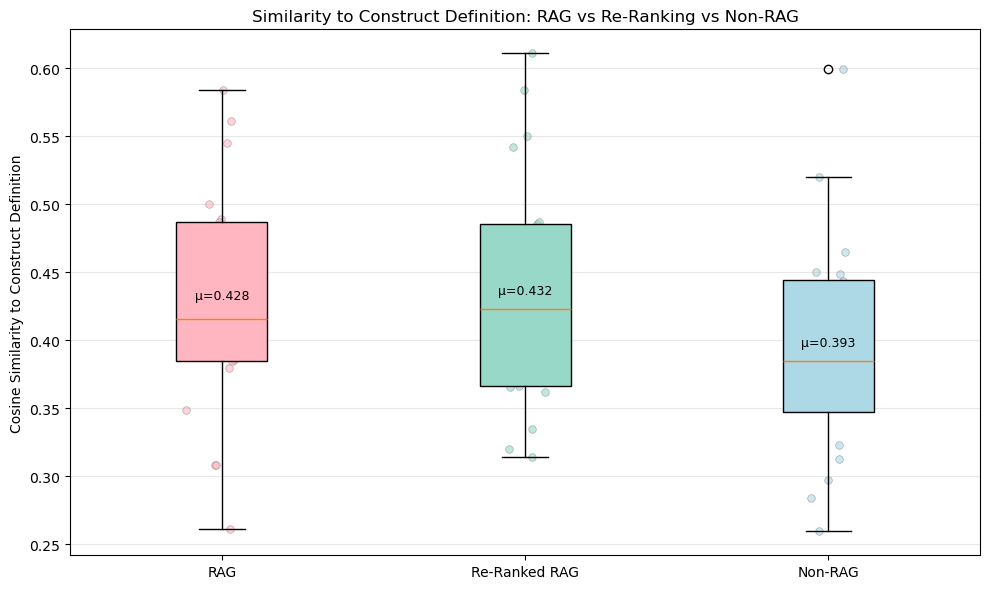


SUMMARY STATISTICS
RAG Mean Similarity: 0.4278 (SD: 0.0824)
Re-Ranked Mean Similarity: 0.4318 (SD: 0.0831)
Non-RAG Mean Similarity: 0.3933 (SD: 0.0801)


In [17]:
# Update box plots

# Create comparison boxplot with all three methods
plt.figure(figsize=(10, 6))
bp = plt.boxplot([rag_similarities, reranked_similarities, no_rag_similarities], 
                  labels=['RAG', 'Re-Ranked RAG', 'Non-RAG'],
                  patch_artist=True)

# Color the boxes
colors = ['#FFB6C1', '#98D8C8', '#ADD8E6']  # pink, mint green, blue
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add individual points with jitter
for i, (similarities, color) in enumerate(zip(
    [rag_similarities, reranked_similarities, no_rag_similarities], colors), 1):
    x = np.random.normal(i, 0.04, size=len(similarities))
    plt.scatter(x, similarities, alpha=0.6, s=30, color=color, 
                edgecolors='gray', linewidth=0.5)

# Add statistics annotation
means = [np.mean(rag_similarities), np.mean(reranked_similarities), np.mean(no_rag_similarities)]
for i, mean in enumerate(means, 1):
    plt.text(i, mean, f'μ={mean:.3f}', ha='center', va='bottom', fontsize=9)

plt.ylabel('Cosine Similarity to Construct Definition')
plt.title('Similarity to Construct Definition: RAG vs Re-Ranking vs Non-RAG')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"RAG Mean Similarity: {np.mean(rag_similarities):.4f} (SD: {np.std(rag_similarities):.4f})")
print(f"Re-Ranked Mean Similarity: {np.mean(reranked_similarities):.4f} (SD: {np.std(reranked_similarities):.4f})")
print(f"Non-RAG Mean Similarity: {np.mean(no_rag_similarities):.4f} (SD: {np.std(no_rag_similarities):.4f})")